## Part 1: Data Selection, Visualization, and Introduction

In [ ]:
! pip install prophet

In [ ]:
""" The data is originated from: https://data.world/data-society/us-air-pollution-data """
DATA_PATH = "./uspollution_pollution_us_2000_2016.csv"

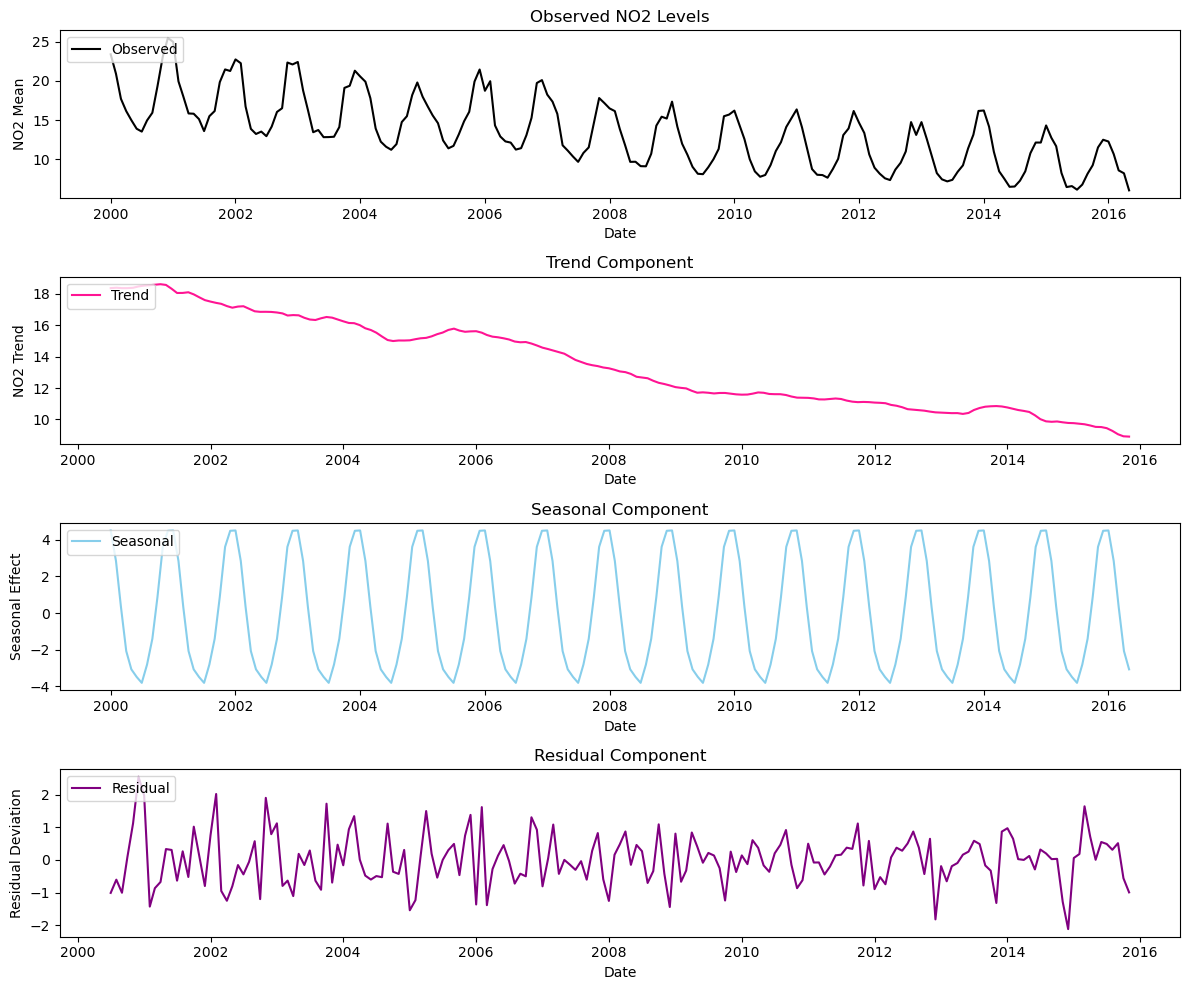

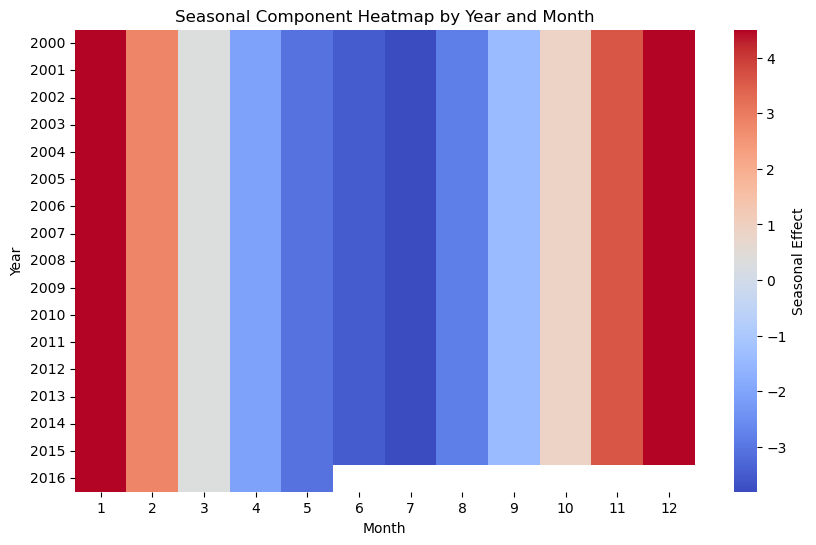

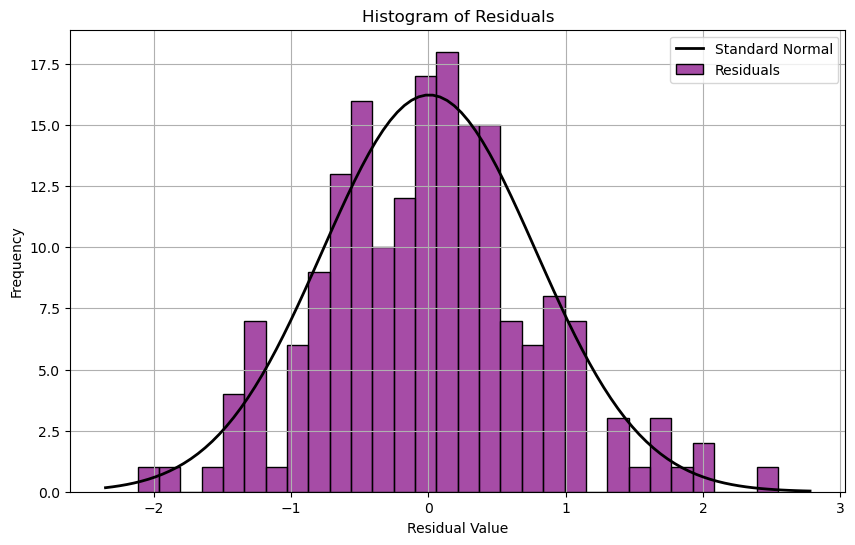

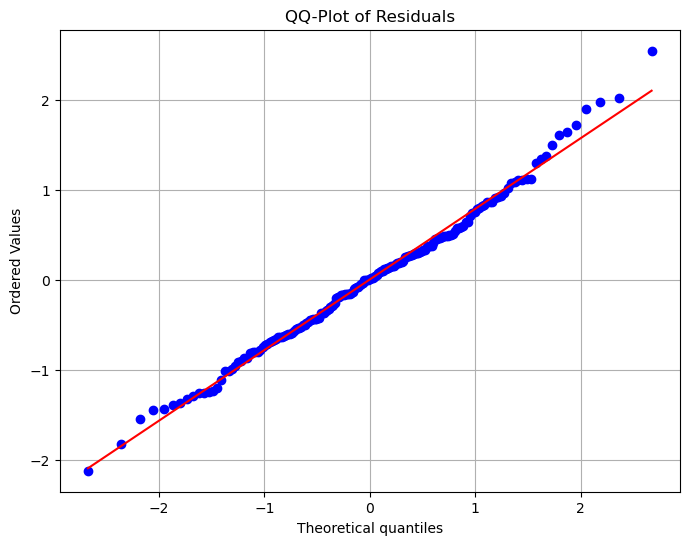

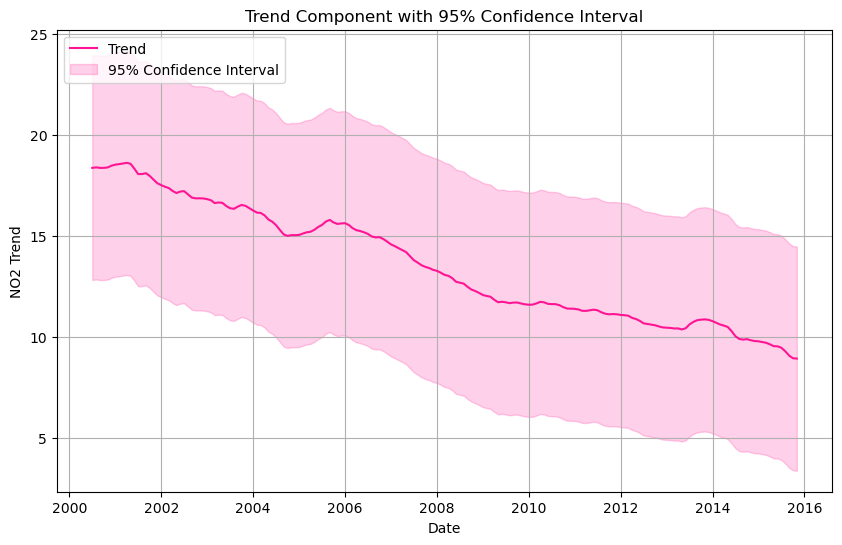

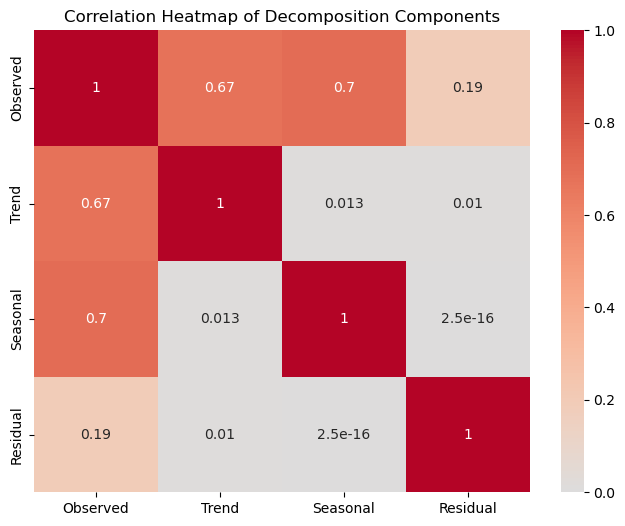

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import scipy.stats as stats

# Load the dataset
df = pd.read_csv(DATA_PATH)

# Convert 'Date Local' to datetime format
df["Date Local"] = pd.to_datetime(df["Date Local"])

# Aggregate by month (compute mean NO2 levels)
df["Year-Month"] = df["Date Local"].dt.to_period("M")  # Group by year-month
df_grouped = df.groupby("Year-Month")["NO2 Mean"].mean()

# Drop missing values
df_grouped = df_grouped.dropna()

# Convert period index to datetime for decomposition
df_grouped.index = df_grouped.index.to_timestamp()

# Perform seasonal decomposition with monthly period
decomposition = seasonal_decompose(df_grouped, model="additive", period=12)  # Monthly seasonality

# Plot decomposition
plt.figure(figsize=(12, 10))

# Observed Component
plt.subplot(4, 1, 1)
plt.plot(decomposition.observed, label="Observed", color="black")
plt.legend(loc="upper left")
plt.title("Observed NO2 Levels")
plt.xlabel("Date")
plt.ylabel("NO2 Mean")

# Trend Component
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label="Trend", color="deeppink")
plt.legend(loc="upper left")
plt.title("Trend Component")
plt.xlabel("Date")
plt.ylabel("NO2 Trend")

# Seasonal Component
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label="Seasonal", color="skyblue")
plt.legend(loc="upper left")
plt.title("Seasonal Component")
plt.xlabel("Date")
plt.ylabel("Seasonal Effect")

# Residual Component
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label="Residual", color="purple")
plt.legend(loc="upper left")
plt.title("Residual Component")
plt.xlabel("Date")
plt.ylabel("Residual Deviation")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Creative Visualizations

# 1. Alternative Seasonal Component Heatmap (without reshaping)
# We'll create a seasonal component over time by extracting the seasonal effects per year
seasonal_df = pd.DataFrame({
    'Date': decomposition.seasonal.index,
    'Seasonal Effect': decomposition.seasonal.values
})

seasonal_df['Month'] = seasonal_df['Date'].dt.month
seasonal_df['Year'] = seasonal_df['Date'].dt.year

# Pivot the seasonal effects by year and month
seasonal_pivot = seasonal_df.pivot(index='Year', columns='Month', values='Seasonal Effect')

plt.figure(figsize=(10, 6))
sns.heatmap(seasonal_pivot, cmap="coolwarm", annot=False, cbar_kws={'label': 'Seasonal Effect'})
plt.title("Seasonal Component Heatmap by Year and Month")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()

# 2. Histogram of Residuals to visualize distribution
plt.figure(figsize=(10, 6))
sns.histplot(decomposition.resid.dropna(), bins=30, kde=False, color='purple', alpha=0.7, label='Residuals')
plt.title("Histogram of Residuals")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")

# Add a line for the standard normal distribution
mu, std = np.mean(decomposition.resid.dropna()), np.std(decomposition.resid.dropna())
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p * len(decomposition.resid.dropna()) * (xmax - xmin) / 30, 'k', linewidth=2, label='Standard Normal')

plt.legend(loc="upper right")
plt.grid(True)
plt.show()

# 2.1 QQ-Plot of Residuals
plt.figure(figsize=(8, 6))
stats.probplot(decomposition.resid.dropna(), dist="norm", plot=plt)
plt.title("QQ-Plot of Residuals")
plt.grid(True)
plt.show()

# 3. Trend with Confidence Interval (using 95% confidence bounds)
plt.figure(figsize=(10, 6))
plt.plot(decomposition.trend, label="Trend", color="deeppink")
plt.fill_between(decomposition.trend.index, 
                 decomposition.trend - 1.96*decomposition.trend.std(), 
                 decomposition.trend + 1.96*decomposition.trend.std(), 
                 color='deeppink', alpha=0.2, label="95% Confidence Interval")
plt.title("Trend Component with 95% Confidence Interval")
plt.xlabel("Date")
plt.ylabel("NO2 Trend")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

# 4. Correlation Heatmap of Observed, Trend, Seasonal, and Residual Components
data = pd.DataFrame({
    'Observed': decomposition.observed,
    'Trend': decomposition.trend,
    'Seasonal': decomposition.seasonal,
    'Residual': decomposition.resid
})

corr_matrix = data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Decomposition Components")
plt.show()

## Part 2: Model Fitting

In [ ]:
!pip install hmmlearn

In [ ]:
!pip install ruptures

In [ ]:
import pandas as pd

def load_data():
    df = pd.read_csv(DATA_PATH)
    df["Date Local"] = pd.to_datetime(df["Date Local"])
    df.set_index("Date Local", inplace=True)
    df_monthly = df.resample("ME")[["NO2 Mean"]].mean().dropna()
    return df_monthly

### Stationary test

ADF Test Results:
ADF Statistic: -0.6544
P-Value: 0.8582
Critical Values:
1%: -3.4670
5%: -2.8776
10%: -2.5754
❌ הנתונים אינם סטציונריים (לא דוחים את השערת האפס), יש צורך בהפרש


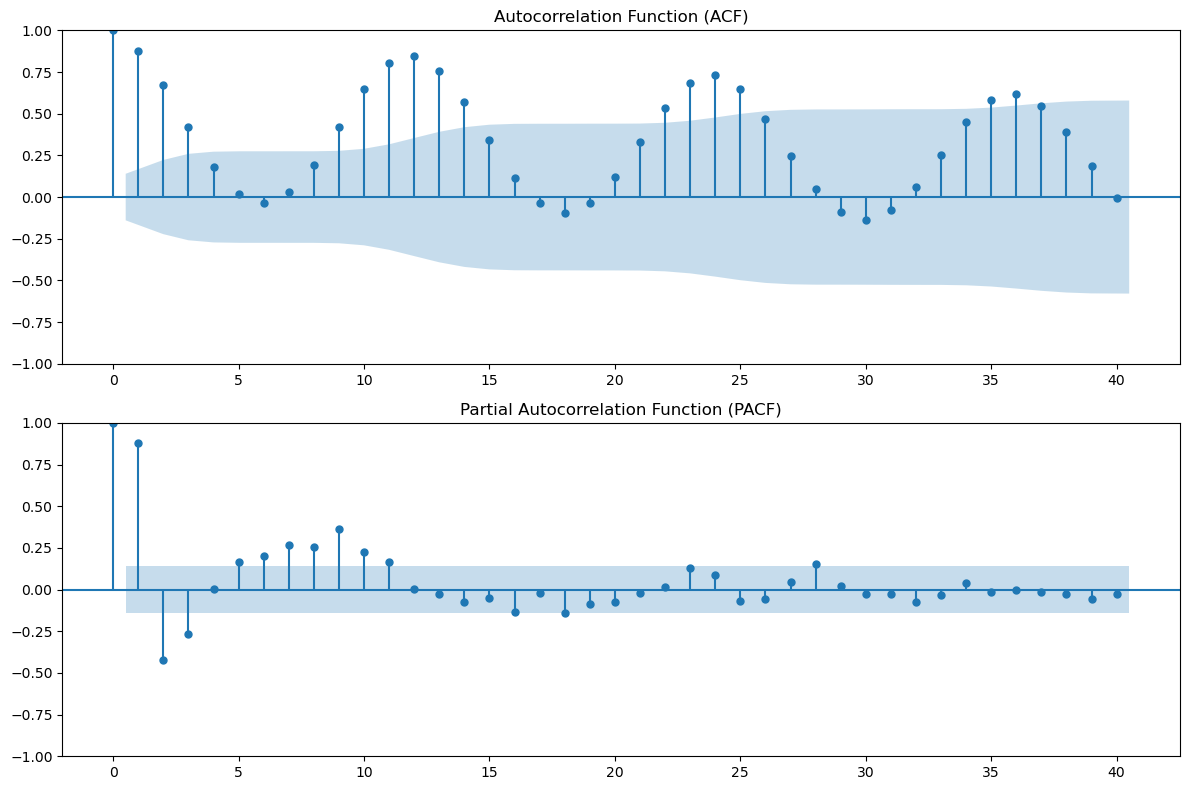

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# טעינת הנתונים
df_monthly = load_data()

### 1. בדיקת סטציונריות עם ADF Test
def adf_test(series):
    result = adfuller(series)
    print("ADF Test Results:")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"P-Value: {result[1]:.4f}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"{key}: {value:.4f}")
    if result[1] < 0.05:
        print("✅ הנתונים סטציונריים (דוחים את השערת האפס)")
    else:
        print("❌ הנתונים אינם סטציונריים (לא דוחים את השערת האפס), יש צורך בהפרש")

# הרצת הבדיקה
adf_test(df_monthly["NO2 Mean"])

### 2. ניתוח ACF ו-PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# גרף ACF (למציאת q)
plot_acf(df_monthly["NO2 Mean"].dropna(), ax=ax[0], lags=40)
ax[0].set_title("Autocorrelation Function (ACF)")

# גרף PACF (למציאת p)
plot_pacf(df_monthly["NO2 Mean"].dropna(), ax=ax[1], lags=40)
ax[1].set_title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()


ADF Test Results:
ADF Statistic: -3.8656
P-Value: 0.0023
Critical Values:
1%: -3.4670
5%: -2.8776
10%: -2.5754
✅ הנתונים סטציונריים (דוחים את השערת האפס)


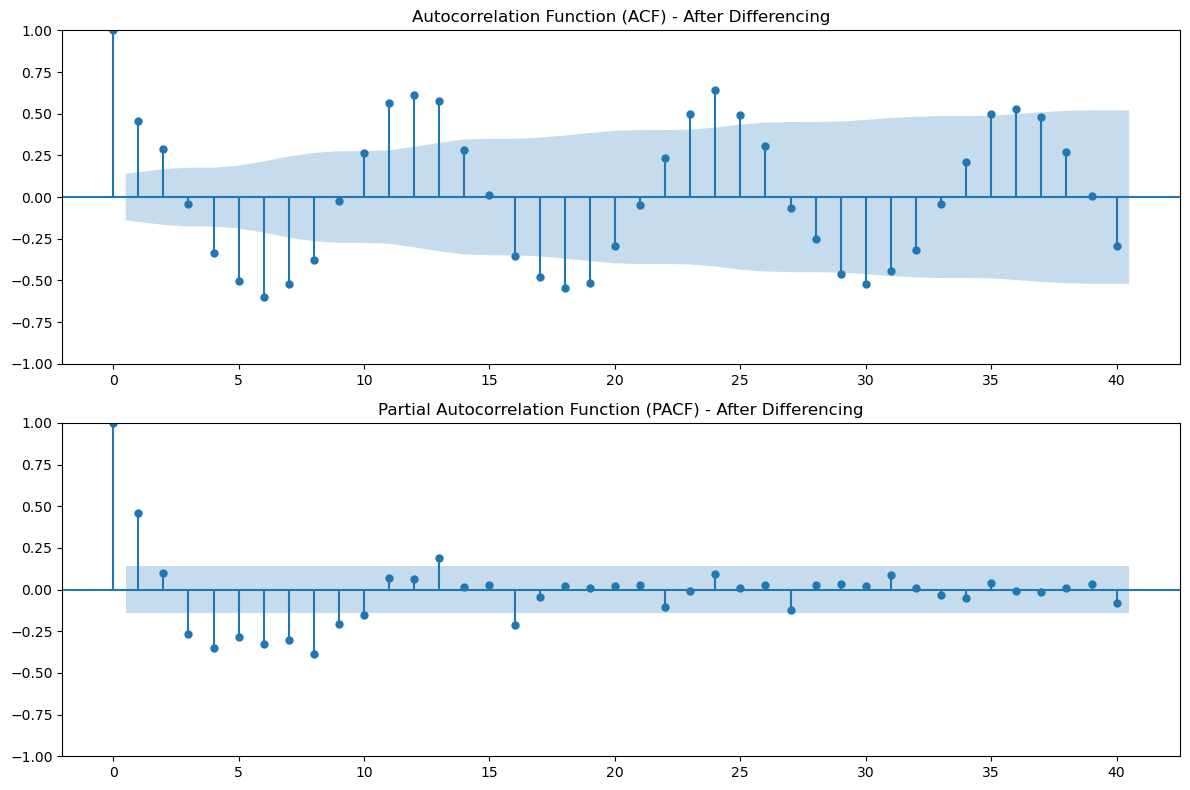

In [2]:
# ביצוע הפרש ראשון
df_monthly_diff = df_monthly.diff().dropna()

# בדיקת ADF מחדש
adf_test(df_monthly_diff["NO2 Mean"])

# ACF and PACF after differencing
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# ACF plot after differencing
plot_acf(df_monthly_diff["NO2 Mean"], ax=ax[0], lags=40)
ax[0].set_title("Autocorrelation Function (ACF) - After Differencing")

# PACF plot after differencing
plot_pacf(df_monthly_diff["NO2 Mean"], ax=ax[1], lags=40)
ax[1].set_title("Partial Autocorrelation Function (PACF) - After Differencing")

plt.tight_layout()
plt.show()


ADF Test Results:
ADF Statistic: -7.0188
P-Value: 0.0000
Critical Values:
1%: -3.4694
5%: -2.8787
10%: -2.5759
✅ הנתונים סטציונריים (דוחים את השערת האפס)


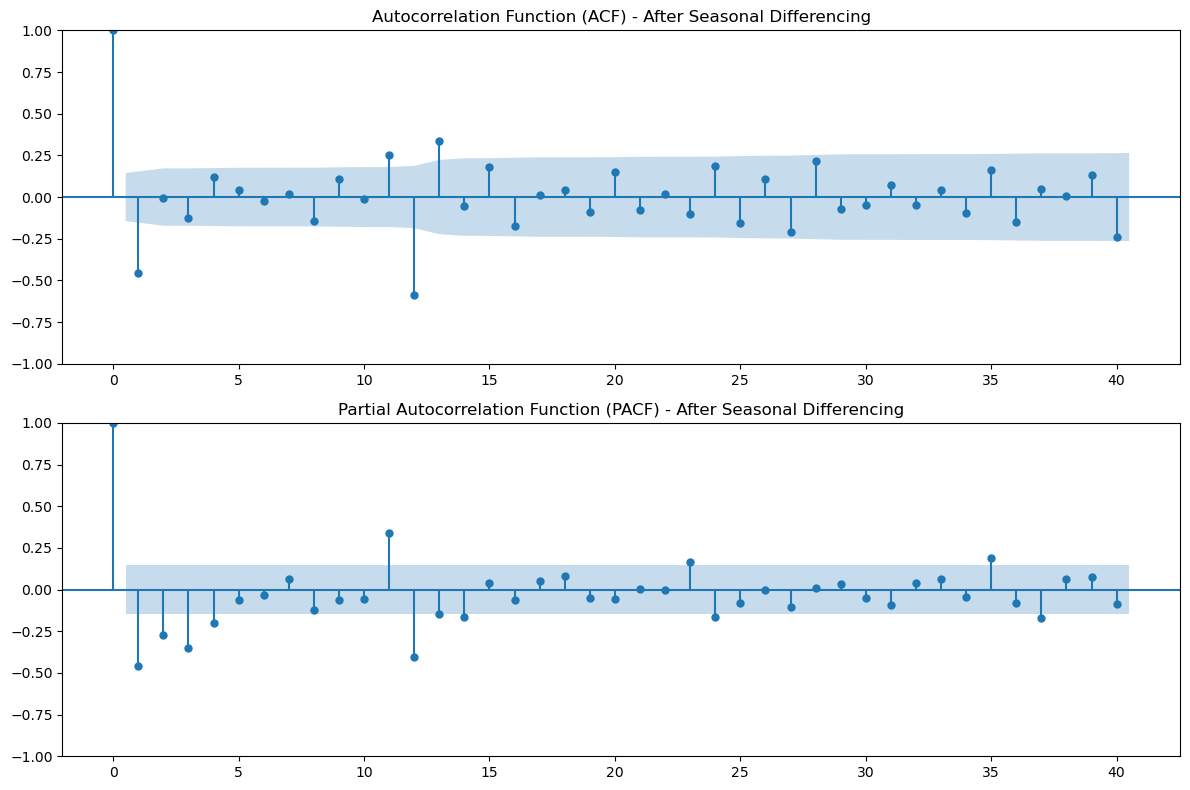

In [3]:
# Apply seasonal differencing
df_monthly_seasonal_diff = df_monthly_diff.diff(12).dropna()

# Run ADF test again
adf_test(df_monthly_seasonal_diff["NO2 Mean"])

# Plot ACF and PACF again
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(df_monthly_seasonal_diff["NO2 Mean"], ax=ax[0], lags=40)
ax[0].set_title("Autocorrelation Function (ACF) - After Seasonal Differencing")

plot_pacf(df_monthly_seasonal_diff["NO2 Mean"], ax=ax[1], lags=40)
ax[1].set_title("Partial Autocorrelation Function (PACF) - After Seasonal Differencing")

plt.tight_layout()
plt.show()


### SARIMA

In [ ]:
# Load dataset
df_monthly = load_data()

# Split into training (all but last year) and testing (last year)
train = df_monthly.iloc[:-12]
test = df_monthly.iloc[-12:]

In [ ]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

# טווח פרמטרים לא-עונתיים
p_values = list(range(1, 6))
d_values = [1]  # We did only 1 differencing
q_values = list(range(1, 3))

# טווח פרמטרים עונתיים
P_values = list(range(0, 4))
D_values = [1]  # We did 1 seasonal differencing
Q_values = list(range(0, 4))
s = 12  # עונתיות של 12 חודשים

# משתנים לשמירת המודל הטוב ביותר
best_aic = float("inf")
best_order_sarima = None
best_seasonal_order = None
best_model = None
counter = 0

# בדיקת כל הצירופים האפשריים
for order in itertools.product(p_values, d_values, q_values):
    for seasonal_order in itertools.product(P_values, D_values, Q_values):
        counter += 1
        try:
            model = SARIMAX(
                df_monthly["NO2 Mean"],  
                order=order, 
                seasonal_order=seasonal_order + (s,),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order_sarima = order
                best_seasonal_order = seasonal_order
                best_model = results
        except:
            continue  # במקרה של שגיאה נמשיך למודל הבא
        print(f"{counter}. Order: {order}, Seasonal Order: {seasonal_order}, AIC: {results.aic:.2f}")


In [23]:
# הצגת התוצאות
best_seasonal_order_with_s = best_seasonal_order + (s,)
print(f"Best AIC: {best_aic:.2f}")
print(f"Best Order: {best_order_sarima}")
print(f"Best Seasonal Order: {best_seasonal_order_with_s}")

Best AIC: 386.22
Best Order: (1, 1, 2)
Best Seasonal Order: (1, 1, 3, 12)


In [ ]:
# SARIMA Model
sarima_model = SARIMAX(train, order=best_order_sarima, seasonal_order=best_seasonal_order_with_s).fit()
forecast_sarima = sarima_model.get_forecast(steps=12).predicted_mean

### Prophet

In [33]:
from prophet import Prophet

# Prophet Model
df_prophet = train.reset_index().rename(columns={"Date Local": "ds", "NO2 Mean": "y"})
prophet_model = Prophet()
prophet_model.fit(df_prophet)
future = prophet_model.make_future_dataframe(periods=12, freq="M")
forecast_prophet = prophet_model.predict(future).iloc[-12:]

22:36:58 - cmdstanpy - INFO - Chain [1] start processing
22:36:59 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\amits\miniconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


### Regression with Fourier Terms

In [29]:
from statsmodels.tsa.deterministic import DeterministicProcess, Fourier
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error

errors = []
best_fourier_order = None

for k in range(1, 6):  # Try different Fourier orders
    dp = DeterministicProcess(
        index=train.index,
        constant=True,  # Include intercept
        order=1,  # Linear trend
        seasonal=True,
        additional_terms=[Fourier(period=12, order=k)]  # Correct Fourier implementation
    )
    
    X_train = dp.in_sample()
    y_train = train["NO2 Mean"]
    
    reg_model = LinearRegression().fit(X_train, y_train)
    
    # Forecast
    X_test = dp.out_of_sample(steps=12)
    forecast = reg_model.predict(X_test)
    
    # Evaluate performance
    mse = mean_squared_error(test["NO2 Mean"], forecast)
    errors.append((k, mse))

# Get best Fourier order
best_fourier_order = min(errors, key=lambda x: x[1])[0]
print(f"Optimal Fourier Order: {best_fourier_order}")

# Polynomial Trend Order Optimization
errors = []
best_order_fourier = None

for order in [0, 1, 2]:  # Try different polynomial orders
    dp = DeterministicProcess(
        index=train.index,
        constant=True,  # Include intercept
        order=order,  # Varies between 0 (no trend), 1 (linear), and 2 (quadratic)
        seasonal=True,  # Include seasonal dummy variables
        additional_terms=[Fourier(period=12, order=best_fourier_order)]  # Correct Fourier implementation
    )
    
    X_train = dp.in_sample()
    y_train = train["NO2 Mean"]
    
    reg_model = LinearRegression().fit(X_train, y_train)
    
    # Forecast
    X_test = dp.out_of_sample(steps=12)
    forecast = reg_model.predict(X_test)
    
    # Evaluate performance
    mse = mean_squared_error(test["NO2 Mean"], forecast)
    errors.append((order, mse))

# Get best polynomial order
best_order_fourier = min(errors, key=lambda x: x[1])[0]
print(f"Optimal Polynomial Order: {best_order_fourier}")

# Regularization (Ridge & Lasso)
X_train = dp.in_sample()
y_train = train["NO2 Mean"]

ridge_model = RidgeCV(alphas=np.logspace(-3, 3, 10))
ridge_model.fit(X_train, y_train)
print(f"Best Ridge Alpha: {ridge_model.alpha_}")

lasso_model = LassoCV(alphas=np.logspace(-3, 3, 10))
lasso_model.fit(X_train, y_train)
print(f"Best Lasso Alpha: {lasso_model.alpha_}")


Optimal Fourier Order: 1
Optimal Polynomial Order: 1
Best Ridge Alpha: 0.46415888336127775
Best Lasso Alpha: 0.004641588833612777


In [ ]:
from statsmodels.tsa.deterministic import Fourier

# Create Deterministic Process with optimized parameters
dp = DeterministicProcess(
    index=train.index,
    constant=True,  # Include intercept
    order=best_order_fourier,  # Optimal polynomial trend order
    seasonal=True,  # Seasonal dummies
    additional_terms=[Fourier(period=12, order=best_fourier_order)]  # Correct Fourier implementation
)

# Generate train features
X_train = dp.in_sample()
y_train = train["NO2 Mean"]

# Fit Ridge Regression with optimized alpha
reg_model = RidgeCV(alphas=[ridge_model.alpha_])
reg_model.fit(X_train, y_train)

# Generate test features and forecast
X_test = dp.out_of_sample(steps=12)
forecast_reg = reg_model.predict(X_test)


### Models' evaluation

SARIMA - MSE: 1.17, MAE: 0.89, MAPE: 8.99%
Prophet - MSE: 0.97, MAE: 0.82, MAPE: 8.35%
Fourier Regression - MSE: 0.82, MAE: 0.83, MAPE: 10.23%


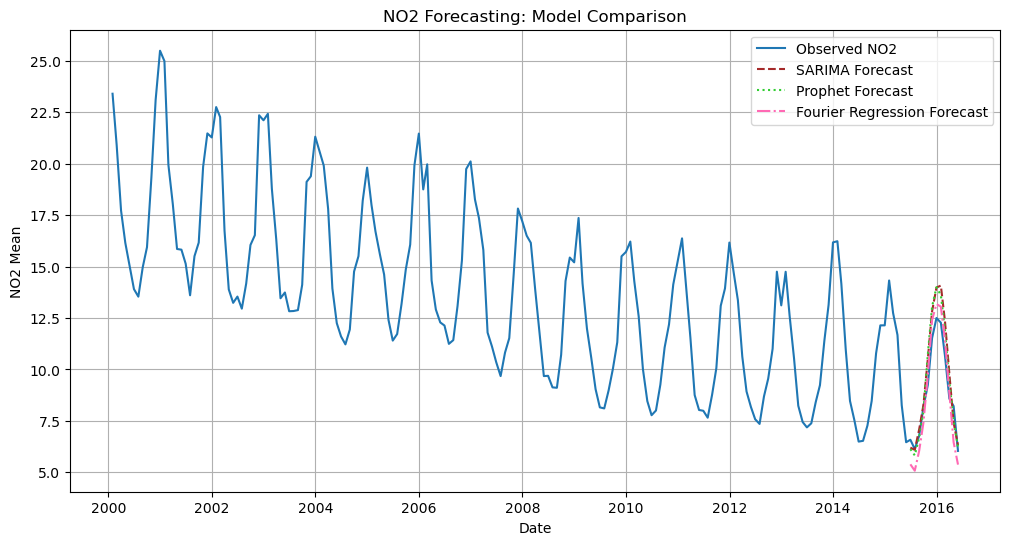

In [34]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error as mape

# Evaluation Metrics
def eval_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape_percent = mape(y_true, y_pred) * 100
    return mse, mae, mape_percent

# Compare Models
test_values = test["NO2 Mean"]
models = {
    "SARIMA": forecast_sarima,
    "Prophet": forecast_prophet["yhat"].values,
    "Fourier Regression": forecast_reg
}

for name, forecast in models.items():
    mse, mae, mape_percent = eval_metrics(test_values, forecast)
    print(f"{name} - MSE: {mse:.2f}, MAE: {mae:.2f}, MAPE: {mape_percent:.2f}%")

# Visual Comparison
plt.figure(figsize=(12,6))
plt.plot(df_monthly, label="Observed NO2")
plt.plot(test.index, forecast_sarima, label="SARIMA Forecast", linestyle="dashed", color='brown')
plt.plot(test.index, forecast_prophet["yhat"].values, label="Prophet Forecast", linestyle="dotted", color="limegreen")
plt.plot(test.index, forecast_reg, label="Fourier Regression Forecast", linestyle="dashdot", color='hotpink')
plt.legend()
plt.title("NO2 Forecasting: Model Comparison")
plt.xlabel("Date")
plt.ylabel("NO2 Mean")
plt.grid(True)
plt.show()

### Forcast for the future

22:54:10 - cmdstanpy - INFO - Chain [1] start processing
22:54:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\amits\miniconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
C:\Users\amits\AppData\Local\Temp\ipykernel_17436\2456660099.py:43: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_reg_series = pd.Series(forecast_reg, index=pd.date_range(start=full_data.index[-1] + pd.DateOffset(months=1), periods=12, freq="M"))


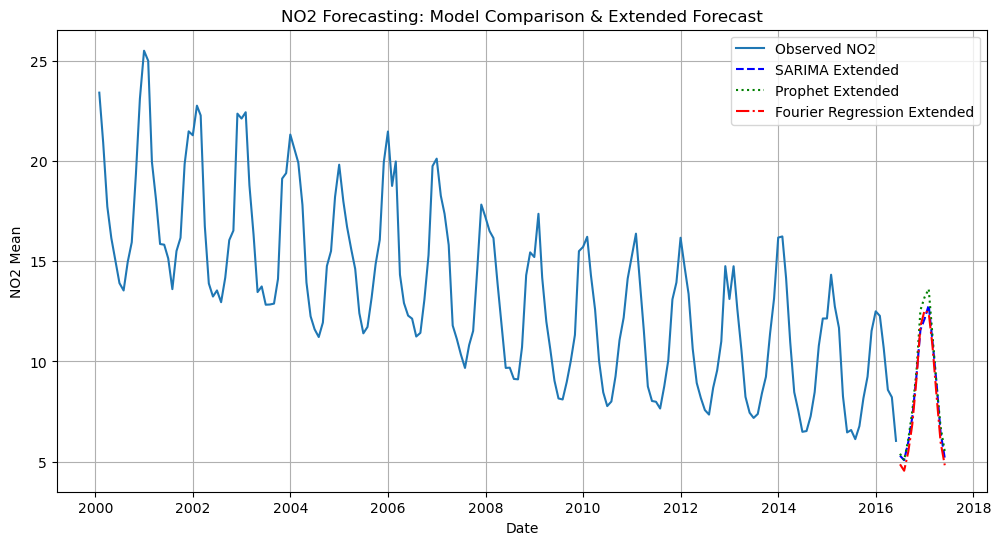

In [46]:
# Extend Forecast for Next 12 Months
full_data = df_monthly[["NO2 Mean"]]  # Use all available data for final training

# SARIMA Extended Forecast
sarima_extended = SARIMAX(full_data, order=best_order_sarima, seasonal_order=best_seasonal_order_with_s).fit()
forecast_sarima_ext = sarima_extended.get_forecast(steps=12).predicted_mean

# Prophet Extended Forecast
df_prophet_full = full_data.reset_index().rename(columns={"Date Local": "ds", "NO2 Mean": "y"})
prophet_model_full = Prophet()
prophet_model_full.fit(df_prophet_full)
future_full = prophet_model_full.make_future_dataframe(periods=12, freq="M")
forecast_prophet_ext = prophet_model_full.predict(future_full).iloc[-12:]

# Fourier Regression Extended Forecast
dp_full = DeterministicProcess(
    index=full_data.index,
    constant=True,  # Include intercept
    order=best_order_fourier,  # Optimal polynomial trend order
    seasonal=True,  # Seasonal dummies
    additional_terms=[Fourier(period=12, order=best_fourier_order)]  # Correct Fourier implementation
)

# Generate train features
X = dp_full.in_sample()
y = full_data["NO2 Mean"]

# Fit Ridge Regression with optimized alpha
reg_model = RidgeCV(alphas=[ridge_model.alpha_])
reg_model.fit(X, y)

# Generate test features and forecast
X_test = dp_full.out_of_sample(steps=12)
forecast_reg = reg_model.predict(X_test)

# Visual Comparison
plt.figure(figsize=(12,6))
plt.plot(full_data, label="Observed NO2")

# Plot extended forecasts
plt.plot(forecast_sarima_ext.index, forecast_sarima_ext, label="SARIMA Extended", linestyle="dashed", color='blue')
plt.plot(forecast_prophet_ext["ds"], forecast_prophet_ext["yhat"].values, label="Prophet Extended", linestyle="dotted", color='green')
forecast_reg_series = pd.Series(forecast_reg, index=pd.date_range(start=full_data.index[-1] + pd.DateOffset(months=1), periods=12, freq="M"))
plt.plot(forecast_reg_series.index, forecast_reg_series, label="Fourier Regression Extended", linestyle="dashdot", color='red')


plt.legend()
plt.title("NO2 Forecasting: Model Comparison & Extended Forecast")
plt.xlabel("Date")
plt.ylabel("NO2 Mean")
plt.grid(True)
plt.show()

## Part 3: Incorporating an Exogenous Variable (O3 levels)

c:\Users\amits\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Exogenous Model Forecast - MSE: 1.12, MAE: 0.87, MAPE: 8.77%


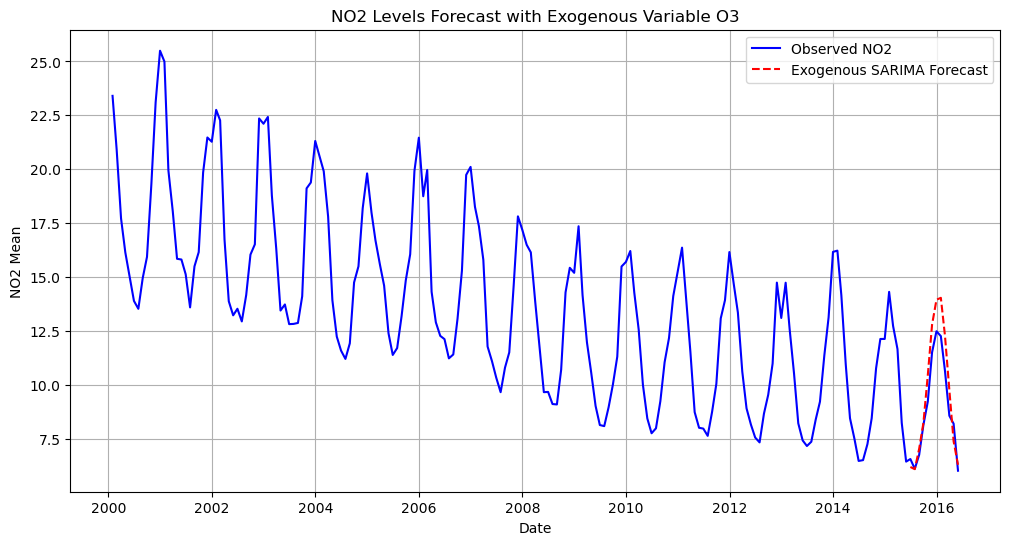

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Load dataset
df_monthly = load_data()

# Split into training (all but last year) and testing (last year)
train = df_monthly.iloc[:-12]
test = df_monthly.iloc[-12:]

# Model fitting with exogenous variable O3
exog_model = SARIMAX(train["NO2 Mean"], exog=train["O3 Mean"], order=best_order_sarima, seasonal_order=best_seasonal_order_with_s).fit()
forecast_exog = exog_model.get_forecast(steps=12, exog=test["O3 Mean"]).predicted_mean

# Evaluation
mse_exog = mean_squared_error(test["NO2 Mean"], forecast_exog)
mae_exog = mean_absolute_error(test["NO2 Mean"], forecast_exog)
mape_exog = mean_absolute_percentage_error(test["NO2 Mean"], forecast_exog)

print("Exogenous Model Forecast - MSE: {:.2f}, MAE: {:.2f}, MAPE: {:.2f}%".format(mse_exog, mae_exog, mape_exog * 100))

# Visual Comparison
plt.figure(figsize=(12, 6))
plt.plot(df_monthly["NO2 Mean"], label="Observed NO2", color="blue")
plt.plot(test.index, forecast_exog, label="Exogenous SARIMA Forecast", linestyle="--", color="red")
plt.title("NO2 Levels Forecast with Exogenous Variable O3")
plt.xlabel("Date")
plt.ylabel("NO2 Mean")
plt.legend()
plt.grid(True)
plt.show()

## Part 4: Change-Point Detection

Pettitt's test between segments 0 and 1 - p-value: 0.0002
Pettitt's test between segments 1 and 2 - p-value: 0.0000
Pettitt's test between segments 2 and 3 - p-value: 0.0000


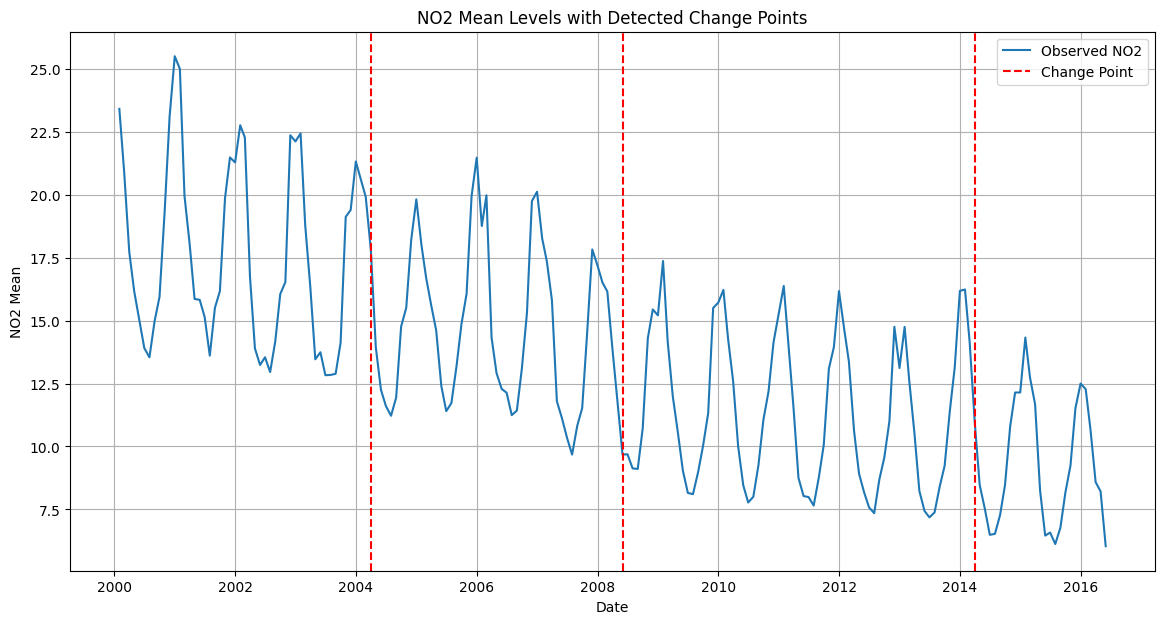

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ruptures import Binseg
from scipy.stats import mannwhitneyu

# Load dataset
df = pd.read_csv("uspollution_pollution_us_2000_2016.csv")
df["Date Local"] = pd.to_datetime(df["Date Local"])
df.set_index("Date Local", inplace=True)

# Change-Point Detection using Binseg
algo = Binseg(model="l2").fit(df_monthly["NO2 Mean"].values)
change_points = algo.predict(n_bkps=3)

# Pettitt's Test for change detection significance
for i in range(1, len(change_points)):
    _, p_value = mannwhitneyu(
        df_monthly["NO2 Mean"].iloc[:change_points[i - 1]],
        df_monthly["NO2 Mean"].iloc[change_points[i - 1]:change_points[i]]
    )
    print(f"Pettitt's test between segments {i-1} and {i} - p-value: {p_value:.4f}")

# Visualization
plt.figure(figsize=(14, 7))
plt.plot(df_monthly, label="Observed NO2")
for cp in change_points[:-1]:
    plt.axvline(df_monthly.index[cp], color='red', linestyle='--', label='Change Point' if cp == change_points[1] else '')
plt.title("NO2 Mean Levels with Detected Change Points")
plt.xlabel("Date")
plt.ylabel("NO2 Mean")
plt.legend()
plt.grid(True)
plt.show()